# The Non Random Two Liquids (NRTL) model for *excess Gibbs energy* ($g^E$) and a case study of Liquid-Liquid equilibria of limonene+water+ethanol

## Feeding the fitted parameters to the model in matrix structure:
we will assemble the parameters in a matrix structure so that we can access each parameter by its index, as in
`A[0,0]` and `A[0,1]`rather than as `A11` and `A12`, so we can loop trough all of them using an iterator, see below:

In [62]:
import numpy as np
from scipy.constants import R

In [63]:
#fited parameters
# chafer's

alpha12=alpha13=alpha23=alpha21=alpha31=alpha23=0.2;


A12=107.99
A21=555.81
A13=1011.98
A31=2277.37
A23=-1113.1
A32=1217.37

alpha = np.array([[0, alpha12, alpha13],
                [alpha12, 0, alpha23],
                [alpha13, alpha23, 0]])

A = np.array([[0, A12, A13],
             [A21, 0, A23],
             [A31, A32, 0]])

In [64]:
from numba import jit
@jit
def Gamma(T,c_x,q_alpha, q_A):
    #note that we used many lines for didatics
    #we can do it in few lines:
    #note that some expression occur more than once below
    #so it may be useful define it as a intermediary recurrent term here
    #and calculate it once to use it then several times
    q_tau     = q_A/T
    q_G       = np.exp(-(q_alpha*q_tau))
    l_D       = ((1/((q_G.T) @ c_x)).T)
    q_E       = (q_tau*q_G) * l_D 
    gamma     = np.exp(((q_E+(q_E.T))-(((q_G * l_D) * (c_x.T)) @ (q_E.T))) @ c_x)
    return gamma

In [65]:
#test it to see that the results are the same
T=293.15
x=np.array([.2,.3,.5]) #normalized
x_as_column = np.array([x]).T
print(Gamma(T,x_as_column,alpha,A)) #test using those trial input

[[ 7.97865398]
 [ 0.31550702]
 [ 0.95773617]]


# Liq-Liq Equilibria Flash
The next step will be using the model in a phase equilibria algorithm, a Liq-Liq equilibria flash calculation

it works as follows:

The degrees of Freedom for a flash calculation are temperature - T, pressure - P and global composition - z


XXX img src from thesis XXX
* ...............  =>guess, xL1 xL2, then calls model(T,P,x)
* ...............//
* .............<=
* T,P,z => algorithm => finds equilibrium xL1 xL2 and BETA

**Equilibriuma criteria**

$$\mu_{i}^{\rm {L1}}=\mu_{i}^{\rm {L2}}, \forall i$$

**Devised algorithm after analytical simplification of repeated contributions:**

$$x_{i}^{\rm {L1}} \gamma_{i}^{\rm {L1}}= x_{i}^{\rm {L2}} \gamma_{i}^{\rm {L2}}, \forall i$$

# algorithm


In [5]:
def ELLflash_explicit(Z,beta0,K0,MODEL):
    beta=prevbeta=beta0
    K=prevK=K0
    
    a = np.zeros(3)
    XI = np.zeros(3)
    XII = np.zeros(3)
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or (max(abs(K-prevK))>0.0001 # convergence criteria
               and looping2 < 100) ): # max number of iterations
        
        #Solve RachfordRice equation with a newton raphson loop
        looping3 = 0
        while ( (looping3 == 0) # means do at least once
               or (abs(beta-prevbeta)>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            prevbeta = beta

            for i in range(3):
                a[i] = ( (K[i]-1) / (1+beta*(K[i]-1)) )            
                
            F=0
            for j in range(3):
                F+=Z[j]*a[j]

            J=0
            for j in range(3):
                J-=Z[j]*a[j]*a[j]
                            
            beta -= F/J

            looping3 = looping3 + 1        

        prevK = K
        
        for i in range(3):
            XI[i] = Z[i] * (1./(1+beta * (K[i]-1))) #Rachford-Rice composition updating scheme
                
        gamaI = MODEL(XI)
        
        for i in range(3):
            XII[i] = K[i]*XI[i]

        gamaII = MODEL(XII)
        
        for i in range(3):
            K[i] = (gamaI[i])/(gamaII[i])
                       
        looping2 = looping2 + 1    

    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100):
        converged = 1
#        print('xi',XI)
#        print('xii',XII)
#        print('beta',beta)
    else:
        converged = 0
#        print('unconverged')
    
    return XI, XII, beta, converged

ztest=np.array([[0.3000,
0.4000,
0.3000]]).T

betatest=0.2966

xitest=np.array([[0.0535,
0.5250,
0.4215]]).T


xiitest=np.array([[0.8845,
0.1035,
0.0120]]).T

ktest=1/(xitest/xiitest)

beta0=betatest*1
k0=ktest*1
Z=ztest

print(T)
print(xitest*Gamma(T,xitest,alpha,A))
print(xiitest*Gamma(T,xiitest,alpha,A))

print('hue')
MODEL = lambda x: Gamma(T,x,alpha,A)
ans=ELLflash_explicit(Z,beta0,k0,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

293.15
[[ 0.9168827 ]
 [ 0.3519015 ]
 [ 0.17377495]]
[[ 0.91689205]
 [ 0.35194092]
 [ 0.17381633]]
hue
[ 0.05349958  0.52504064  0.42145977]
[ 0.88449314  0.10350801  0.01199885]
[ 0.29663337]
1


In [6]:
%timeit ans=ELLflash_explicit(Z,beta0,k0,MODEL)

10000 loops, best of 3: 176 µs per loop


In [7]:
def ELLflash(Z,beta0,K0,MODEL): #ELLflash_linalg
    beta=prevbeta=beta0
    K=prevK=K0
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((np.linalg.norm(K-prevK))>0.0001 # convergence criteria
               and looping2 < 1000) ): # max number of iterations
        looping3 = 0
        while ( (looping3 == 0)
               or (np.linalg.norm(beta-prevbeta)>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            prevbeta = beta
            
            a = (1/(1+beta*(K-1))) * (K-1)
            beta = beta+(1/((Z.T*a.T) @ a)) @ (Z.T @ a)
            
            looping3 += 1        

        prevK = K
        XI = (1./(1+beta * (K-1))) * Z

        gamaI = MODEL(XI)
        
        XII = K*XI

        gamaII = MODEL(XII)
        
        K = (gamaI)/(gamaII)
                       
        looping2 += 1    

    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100):
        converged = 1
#        print('xi',XI)
#        print('xii',XII)
#        print('beta',beta)
    else:
        converged = 0
#        print('unconverged')
    
    return XI, XII, beta, converged

In [8]:
%timeit ans=ELLflash(Z,beta0,k0,MODEL)
ans=ELLflash(Z,beta0,k0,MODEL)
print(ans)

The slowest run took 10328.73 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 118 µs per loop
(array([[ 0.05351685],
       [ 0.52503396],
       [ 0.42144919]]), array([[ 0.88451549],
       [ 0.10349176],
       [ 0.01199276]]), array([[ 0.29661078]]), 1)


In [9]:
@jit(nopython=True)
def ELLflash_fast(Z,beta0,K0,alpha,A):
    beta=beta0.copy()
    prevbeta=beta.copy()
    K=K0.copy()
    prevK=K.copy()
    XI=Z.copy()
    XII=Z.copy()
    looping2=0
    looping3=0
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((np.linalg.norm(K-prevK))>0.0001 # convergence criteria
               and looping2 < 1000) ): # max number of iterations
        looping3 = 0
        while ( (looping3 == 0)
               or (np.linalg.norm(beta-prevbeta)>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            prevbeta = beta
            
            a = (1/(1+beta*(K-1))) * (K-1)
            beta = beta+(1/((Z.T*a.T) @ a)) @ (Z.T @ a)
            
            looping3 += 1        

        prevK = K
        XI = (1./(1+beta * (K-1))) * Z

        gamaI = Gamma(T,XI,alpha,A)
        
        XII = K*XI

        gamaII = Gamma(T,XII,alpha,A)
        
        K = (gamaI)/(gamaII)
                       
        looping2 += 1    

    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100):
        converged = 1
#        print('xi',XI)
#        print('xii',XII)
#        print('beta',beta)
    else:
        converged = 0
#        print('unconverged')
    
    return XI, XII, beta, converged

In [10]:
BETA0=np.array([[beta0]])
%timeit ans=ELLflash_fast(Z,BETA0*1.5,k0,alpha,A)
#ans=ELLflash_fast(Z,BETA0*1.5,k0,alpha,A)
#print(Z,BETA0,k0,alpha,A)
print(ans)
#print(ans[0])

The slowest run took 35003.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 91.1 µs per loop
(array([[ 0.05351685],
       [ 0.52503396],
       [ 0.42144919]]), array([[ 0.88451549],
       [ 0.10349176],
       [ 0.01199276]]), array([[ 0.29661078]]), 1)


In [11]:
from scipy import optimize as opt

def ELLflash_sci(Z,beta0,K0,MODEL):
        
    #prepare FP input
    def fix(kxixiibeta):
        #local varaibles translation
        K=np.array([kxixiibeta[0:3]]).T
        beta0 = np.array([[kxixiibeta[9]]])
        
        #prepare NR input
        F = lambda beta, K=K, Z=Z: (Z.T @ ((1/(1+beta*(K-1))) * (K-1)))
        J = lambda beta, K=K, Z=Z: -(((Z.T*((1/(1+beta*(K-1))) * (K-1)).T) @ ((1/(1+beta*(K-1))) * (K-1))))
        
        #run NR
        beta = opt.newton(func=F,x0=beta0,fprime=J,tol=1e-5, maxiter=50)
        
        #run XI, gammaI, XII, gammaII
        XI = (1./(1+beta * (K-1))) * Z
        gamaI = MODEL(XI)
        XII = K*XI
        gamaII = MODEL(XII)
        
        #prepare return-format solution
        return np.concatenate( ( ((gamaI)/(gamaII))[0:,0], XI[0:,0], XII[0:,0], beta[0:,0] ), axis=0 )
    
    #prepare FP input
    point0 = np.concatenate( ( K0[0:,0], np.zeros(3), np.zeros(3), beta0[0:,0] ), axis=0 )

    #run FP
    point = opt.fixed_point(func = fix, x0 = point0, xtol=1e-08, maxiter=500)
    
    #prepare return-format solution
    K = np.array([point[0:3]]).T
    XI = np.array([point[3:6]]).T
    XII = np.array([point[6:9]]).T
    beta = np.array([point[9:10]]).T
    converged=1
    
    return XI, XII, beta, converged

ans=ELLflash_sci(Z,BETA0*1.4,k0*1.1,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

[[ 0.05351685]
 [ 0.52503396]
 [ 0.42144919]]
[[ 0.88451549]
 [ 0.10349176]
 [ 0.01199276]]
[[ 0.29661078]]
1


In [12]:
ans=ELLflash_sci(Z,BETA0*1.5,k0*1.1,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

[[ 0.05351685]
 [ 0.52503396]
 [ 0.42144919]]
[[ 0.88451549]
 [ 0.10349176]
 [ 0.01199276]]
[[ 0.29661078]]
1


In [13]:
BETA0=np.array([[beta0]])
%timeit ans=ELLflash_sci(Z,BETA0,k0,MODEL)
print(Z,BETA0,k0,alpha,A)
print(ans)
print(ans[0])

The slowest run took 5.35 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.12 ms per loop
[[ 0.3]
 [ 0.4]
 [ 0.3]] [[ 0.2966]] [[ 16.52779552]
 [  0.1971144 ]
 [  0.02845599]] [[ 0.   0.2  0.2]
 [ 0.2  0.   0.2]
 [ 0.2  0.2  0. ]] [[    0.     107.99  1011.98]
 [  555.81     0.   -1113.1 ]
 [ 2277.37  1217.37     0.  ]]
(array([[ 0.05351685],
       [ 0.52503396],
       [ 0.42144919]]), array([[ 0.88451549],
       [ 0.10349176],
       [ 0.01199276]]), array([[ 0.29661078]]), 1)
[[ 0.05351685]
 [ 0.52503396]
 [ 0.42144919]]


In [14]:
ztest=np.array([[0.3000,
0.4000,
0.3000]]).T

betatest=0.2966

xitest=np.array([[0.0535,
0.5250,
0.4215]]).T


xiitest=np.array([[0.8845,
0.1035,
0.0120]]).T

ktest=1/(xitest/xiitest)

beta0=betatest*1
k0=ktest*1
Z=ztest

print(T)
print(xitest*Gamma(T,xitest,alpha,A))
print(xiitest*Gamma(T,xiitest,alpha,A))

print('hue')
MODEL = lambda x: Gamma(T,x,alpha,A)
ans=ELLflash(Z,beta0,k0,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

293.15
[[ 0.9168827 ]
 [ 0.3519015 ]
 [ 0.17377495]]
[[ 0.91689205]
 [ 0.35194092]
 [ 0.17381633]]
hue
[[ 0.05351624]
 [ 0.52503406]
 [ 0.4214497 ]]
[[ 0.88451339]
 [ 0.10349332]
 [ 0.01199329]]
[[ 0.29661204]]
1


In [15]:
%timeit ans=ELLflash(Z,beta0,k0,MODEL)

The slowest run took 20.43 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 750 µs per loop


# initial guess


In [61]:
#Estimativas Iniciais

def iguess(Z,MODEL):
    #print(Z)
    X0 = Z
    gama0 = MODEL(X0)
    
    Xlin = 1/(gama0.T @ Z) * (gama0*Z)

    gamalin = MODEL(Xlin)

    Klin = (1./gamalin) * gama0

    KlinMin = np.min(Klin)
    KlinMax = np.max(Klin)

    nI0 = (KlinMax - Klin) * Z

    XI0 = 1/(np.sum(nI0)) * nI0

    gamaI0=MODEL(XI0)

    nII0=(Klin-KlinMin) * Z

    XII0=1/(np.sum(nII0)) * nII0;

    gamaII0=MODEL(XII0)

    beta0 = np.array([[ 1/(KlinMax-KlinMin) * np.sum(nII0) ]])
    
    K0 = (gamaI0)/(gamaII0)

    return beta0, K0

In [36]:
ztest=np.array([[0.3000,
0.4000,
0.3000]]).T
betatest=0.2966
xitest=np.array([[0.0535,
0.5250,
0.4215]]).T
xiitest=np.array([[0.8845,
0.1035,
0.0120]]).T
ktest=1/(xitest/xiitest)

###

Z=ztest

print(T)
print(xitest*Gamma(T,xitest,alpha,A))
print(xiitest*Gamma(T,xiitest,alpha,A))

print('hue')
MODEL = lambda x: Gamma(T,x,alpha,A)

iguesses = iguess(Z,MODEL)

beta0 = iguesses[0]
K0 = iguesses[1]

print(beta0)
print(K0)

ans=ELLflash(Z,beta0,K0,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

293.15
[[ 0.9168827 ]
 [ 0.3519015 ]
 [ 0.17377495]]
[[ 0.91689205]
 [ 0.35194092]
 [ 0.17381633]]
hue
[[ 0.39441162]]
[[ 35.40198618]
 [  0.21977285]
 [  0.14735411]]
[[ 0.05351532]
 [ 0.52503359]
 [ 0.42145109]]
[[ 0.88450404]
 [ 0.10350028]
 [ 0.01199568]]
[[ 0.29661616]]
1


# grid calc plot

In [60]:
Z1 = np.linspace(0,1,10)
Z2 = np.linspace(0,1,10)
Z3 = np.linspace(0,1,10)

Z1[0]=1e-9
Z2[0]=1e-9
Z3[0]=1e-9
Z1[-1]=1-1e-9
Z2[-1]=1-1e-9
Z3[-1]=1-1e-9

rawZs = np.ndarray((10,10), dtype=object)

flags = np.zeros((10,10))

for i in range(10):
    for j in range(10):
        rawZs[i,j]=np.array([Z1[i],Z2[j],1-Z1[i]-Z2[j]])
        if ( rawZs[i,j][0] + rawZs[i,j][1] +  rawZs[i,j][2] == 1 ):
            flags[i,j] = 1
            
Zs = rawZs[np.where(flags==1)]

npts = Zs.shape[0]
print(npts)

Resultados_beta = np.zeros([npts])
Resultados_conv = np.zeros([npts])
Resultados_Z = np.zeros([3,npts])
Resultados_XI = np.zeros([3,npts])
Resultados_XII = np.zeros([3,npts])

l=0
for k in range(npts):
    MODEL = lambda x: Gamma(T,x,alpha,A)
    beta0, K0 = iguess(np.array([Zs[k]]).T,MODEL)
    print(beta0,K0)
    #print(Zs[k],beta0,K0)
    ans = ELLflash(np.array([Zs[k]]).T,beta0,K0,MODEL)
    
    #http://www.scipy-lectures.org/intro/language/exceptions.html
    #ans = ELLflash_sci(np.array([Zs[k]]).T,beta0,K0,MODEL)
    if (0<ans[2] and 1>ans[2] and ans[3]==1):
        #print(ans[0][0][0],ans[0][1][0],ans[0][2][0])
        Resultados_XI[:,l] = np.array([ans[0][0][0],ans[0][1][0],ans[0][2][0]])
        Resultados_XII[:,l] = np.array([ans[1][0][0],ans[1][1][0],ans[1][2][0]])
        Resultados_beta[l] = ans[2]
        Resultados_conv[l] = ans[3]
        
        l+=1
        
    print(ans[3], ans[2])
        
print('done',l)
    
ndone=l-1

89
[[  1.00000000e-09]
 [  1.00000000e-09]
 [  9.99999998e-01]]
[[  1.35496328e-09]] [[  1.20979301e+04]
 [  6.77605603e-03]
 [  4.42868141e-01]]
0 [[ -2.42223156e+60]]
[[  1.00000000e-09]
 [  1.11111111e-01]
 [  8.88888888e-01]]
[[ 0.32077038]] [[  1.37328363e+02]
 [  4.86584819e-02]
 [  1.69205675e+00]]
0 [[ 0.11535994]]
[[  1.00000000e-09]
 [  2.22222222e-01]
 [  7.77777777e-01]]
[[ 0.35760129]] [[  5.60978824e+02]
 [  2.36347113e-02]
 [  3.21935587e+00]]
0 [[ 0.25949876]]
[[  1.00000000e-09]
 [  3.33333333e-01]
 [  6.66666666e-01]]
[[ 0.53501569]] [[  5.64194034e+02]
 [  2.35811673e-02]
 [  3.23140490e+00]]
0 [[ 0.40363756]]
[[  1.00000000e-09]
 [  4.44444444e-01]
 [  5.55555555e-01]]
[[ 0.33388763]] [[  1.52706872e-03]
 [  4.48541263e+01]
 [  2.79491124e-01]]
0 [[ 0.45222364]]
[[  1.00000000e-09]
 [  5.55555556e-01]
 [  4.44444443e-01]]
[[ 0.30416967]] [[  1.05750805e-03]
 [  4.99874757e+01]
 [  2.08419030e-01]]
0 [[ 0.30808484]]
[[  1.00000000e-09]
 [  6.66666667e-01]
 [  3.33333

/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in true_divide
/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide


0 [[ 0.38591011]]
[[ 0.11111111]
 [ 0.44444444]
 [ 0.44444444]]
[[ 0.13913024]] [[ 40.15101295]
 [  0.19141552]
 [  0.10512607]]
1 [[ 0.08348664]]
[[ 0.11111111]
 [ 0.55555556]
 [ 0.33333333]]
[[ 0.13421334]] [[ 23.37958433]
 [  0.23080645]
 [  0.0549264 ]]
1 [[ 0.04467854]]
[[ 0.11111111]
 [ 0.77777778]
 [ 0.11111111]]
[[ 0.15342617]] [[ 10.77325506]
 [  0.36010868]
 [  0.0892896 ]]
0 [[-0.46432361]]
[[ 0.11111111]
 [ 0.88888889]
 [ 0.        ]]
[[ 0.21005868]] [[ 6.5820161 ]
 [ 0.55048326]
 [ 0.22906191]]
0 [[-489.21775036]]
[[  2.22222222e-01]
 [  1.00000000e-09]
 [  7.77777777e-01]]
[[ 0.22443514]] [[  1.33422102e+04]
 [  4.83245808e-03]
 [  7.04958005e-03]]
1 [[ 0.22367347]]
[[ 0.22222222]
 [ 0.11111111]
 [ 0.66666667]]
[[ 0.25092929]] [[  1.29758975e+03]
 [  1.95158110e-02]
 [  7.14686795e-02]]
1 [[ 0.22319447]]
[[ 0.22222222]
 [ 0.22222222]
 [ 0.55555556]]
[[ 0.3842647]] [[  1.23257811e+03]
 [  3.40604283e-02]
 [  1.22980828e+00]]
0 [[ 0.2765407]]
[[ 0.22222222]
 [ 0.33333333]
 

/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in multiply


0 [[ 0.32303366]]
[[ 0.55555556]
 [ 0.33333333]
 [ 0.11111111]]
[[ 0.61535745]] [[  1.76010126e+01]
 [  2.15547226e-01]
 [  1.46376150e-02]]
1 [[ 0.6586498]]
[[ 0.55555556]
 [ 0.44444444]
 [ 0.        ]]
[[ 0.23068734]] [[  0.11925732]
 [  2.71080041]
 [ 14.39741489]]
0 [[-273.28609121]]
[[ 0.55555556]
 [ 0.55555556]
 [-0.11111111]]
[[ 0.46510812]] [[  1.42823252e-01]
 [  1.95163666e+01]
 [  3.12973286e+03]]
1 [[ nan]]
[[ 0.55555556]
 [ 0.66666667]
 [-0.22222222]]
[[ 0.56294672]] [[  3.66367370e-01]
 [  2.70608793e+07]
 [  2.17593281e+06]]
1 [[ nan]]
[[ 0.55555556]
 [ 0.77777778]
 [-0.33333333]]
[[ 0.68391414]] [[  2.47616817e+027]
 [  1.74970380e+162]
 [  1.12030583e+078]]
1 [[ nan]]
[[ 0.55555556]
 [ 0.88888889]
 [-0.44444444]]
[[ 0.81804]] [[  6.16481908e+10]
 [  3.58437443e+23]
 [  5.98926639e+14]]
1 [[ nan]]
[[ 0.55555556]
 [ 1.        ]
 [-0.55555555]]
[[ 0.96514506]] [[  5.43163527e+02]
 [  4.28383405e+00]
 [  9.70250486e+03]]
1 [[ nan]]
[[  6.66666667e-01]
 [  1.00000000e-09]
 

/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in true_divide
/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in true_divide


1 [[ nan]]
[[ 0.88888889]
 [ 0.55555556]
 [-0.44444444]]
[[ 0.42059168]] [[  1.30302176e+03]
 [  3.27417478e+32]
 [  1.00924211e+18]]
1 [[ nan]]
[[ 0.88888889]
 [ 0.77777778]
 [-0.66666667]]
[[ 0.67271519]] [[  6.98238274e+16]
 [  1.31117549e+43]
 [  1.23545729e+24]]
0 [[  1.73711872e+120]]
[[ 0.88888889]
 [ 0.88888889]
 [-0.77777778]]
[[ 0.79503017]] [[   267395.08113133]
 [ 34069313.29135694]
 [ 16757016.56919817]]
1 [[ nan]]
[[  9.99999999e-01]
 [  1.00000000e-09]
 [ -2.82819315e-17]]
[[  8.41787506e-11]] [[  1.06649829e-01]
 [  5.29103252e+00]
 [  1.19042024e+03]]
0 [[ -1.79877731e+60]]
[[ 1.        ]
 [ 0.11111111]
 [-0.11111111]]
[[-0.10929321]] [[  4.77751508e-05]
 [  2.83755445e+02]
 [  1.69181751e+01]]
1 [[ nan]]
[[ 1.        ]
 [ 0.22222222]
 [-0.22222222]]
[[-0.08768528]] [[  7.81376918e+00]
 [  3.61681497e+29]
 [  2.16697599e+23]]
1 [[ nan]]
[[ 1.        ]
 [ 0.33333333]
 [-0.33333333]]
[[ 0.1643305]] [[  4.01404296e-01]
 [  8.52131966e+04]
 [  4.19449741e+05]]
1 [[ nan]]
[

/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in multiply


In [38]:
fResultados_XI = Resultados_XI[:,np.where(Resultados_conv==1)]
fResultados_XII = Resultados_XII[:,np.where(Resultados_conv==1)]
fResultados_beta = Resultados_beta[np.where(Resultados_conv==1)]

In [39]:
print(Resultados_XI[:,3]) #ERRADO AQUI

[ 0.07701796  0.57482715  0.3481549 ]


In [40]:
print(fResultados_XI[:,0,3]) #ERRADO AQUI

[ 0.07701796  0.57482715  0.3481549 ]


In [41]:
test_data1 = np.zeros([ndone,3])
test_data2 = np.zeros([ndone,3])

from matplotlib import pyplot as plt

for k in range(ndone):
    #print(Resultados_XI[:,0])
    test_data1[k,0:3] = fResultados_XI[:,0,k]
    test_data2[k,0:3] = fResultados_XII[:,0,k]
    #test_data[l,3] = GM[l]

print(test_data1[:,:])
    
a=test_data1[:,0]
b=test_data1[:,1]



[[  7.48369985e-05   0.00000000e+00   9.99925163e-01]
 [  5.06591101e-03   2.47727880e-01   7.47206209e-01]
 [  3.79820203e-02   4.77942870e-01   4.84075110e-01]
 [  7.70179575e-02   5.74827147e-01   3.48154896e-01]
 [  7.48369985e-05   0.00000000e+00   9.99925163e-01]
 [  1.30275990e-03   1.42079783e-01   8.56617457e-01]
 [  5.54476546e-02   5.29938099e-01   4.14614246e-01]
 [  1.14258588e-01   6.24349934e-01   2.61391479e-01]
 [  2.20234331e-01   6.68236475e-01   1.11529194e-01]
 [  7.48369985e-05   0.00000000e+00   9.99925163e-01]
 [  1.81433540e-03   1.64847881e-01   8.33337783e-01]
 [  8.57278213e-02   5.88977067e-01   3.25295112e-01]
 [  1.86217735e-01   6.65388017e-01   1.48394248e-01]
 [  9.93252015e-01   0.00000000e+00   6.74798482e-03]
 [  9.87625510e-01   7.07708078e-03   5.29740927e-03]
 [  1.46869522e-01   6.49795530e-01   2.03334948e-01]
 [  9.93252015e-01   0.00000000e+00   6.74798543e-03]
 [  9.83072097e-01   1.16800686e-02   5.24783476e-03]
 [  1.03514160e-01   6.12725

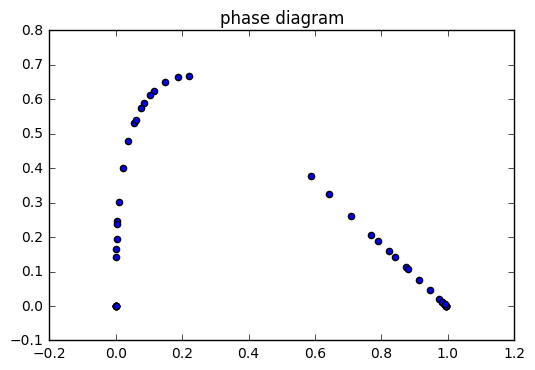

In [42]:

# barycentric coords: (a,b,c)
a=test_data1[:,0]
b=test_data1[:,1]
c=test_data1[:,2]

d=test_data2[:,0]
e=test_data2[:,1]
f=test_data2[:,2]

# create a triangulation out of these points
#Tri = tri.Triangulation(cartx,carty)
#Tri = tri.Triangulation(a,b)

# plot the contour
#plt.tricontourf(cartx,carty,Tri.triangles,v)
#plt.tricontourf(a,b,Tri.triangles,v)


# create the grid
#corners = np.array([[0, 0], [1, 0], [0.5,  np.sqrt(3)*0.5]])
#corners = np.array([[0, 0], [1, 0], [0,1]])
#triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# creating the grid
#refiner = tri.UniformTriRefiner(triangle)
#trimesh = refiner.refine_triangulation(subdiv=4)

#plotting the mesh
#plt.triplot(trimesh,'k--')

plt.scatter(a,b)
plt.scatter(d,e)
plt.title('phase diagram')
#plt.axis('off')
plt.show()

In [43]:
#determinar pto crítico
xcrit=0.4 #aprox.


#refiltrar a e b

al=a[np.where(a<=0.4)]
ar=a[np.where(a>0.4)]
dl=d[np.where(d<=0.4)]
dr=d[np.where(d>0.4)]

bl=b[np.where(a<=0.4)]
br=b[np.where(a>0.4)]
el=e[np.where(d<=0.4)]
er=e[np.where(d>0.4)]

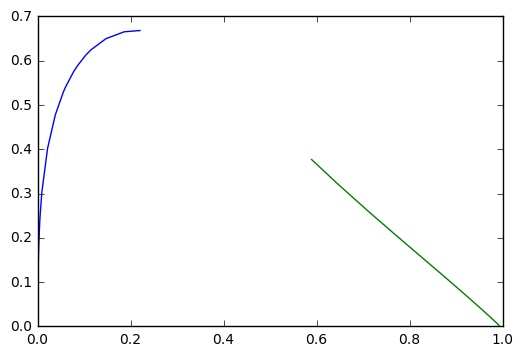

[  7.48369985e-05   5.06591101e-03   3.79820203e-02   7.70179575e-02
   7.48369985e-05   1.30275990e-03   5.54476546e-02   1.14258588e-01
   2.20234331e-01   7.48369985e-05   1.81433540e-03   8.57278213e-02
   1.86217735e-01   1.46869522e-01   1.03514160e-01   7.48369985e-05
   2.73918277e-03   7.48369985e-05   4.61002813e-03   7.48369985e-05
   8.97108985e-03   5.98194015e-02   7.48369985e-05   2.11675118e-02]


In [44]:
Ly = np.concatenate((al,dl),axis=0)
Lx = np.concatenate((bl,el),axis=0)

Ry = np.concatenate((ar,dr),axis=0)
Rx = np.concatenate((br,er),axis=0)

sLy=np.sort(Ly)
sLx=np.sort(Lx)
sRy=np.sort(Ry)
sRx=-np.sort(-Rx)

plt.plot(sLy,sLx)
plt.plot(sRy,sRx)

plt.show()

print(Ly)

#now the tielines



(24,) (24,) (24,) (24,)
(15,) (15,) (9,) (9,)
(9,) (9,) (15,) (15,)


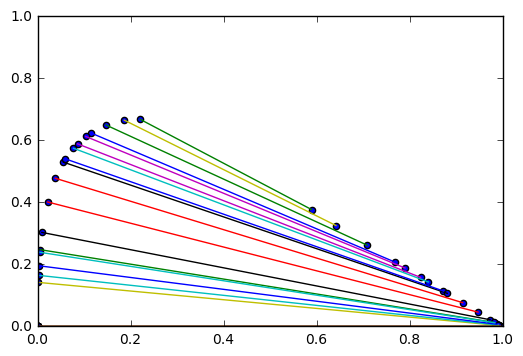

(9,)
(9,)
7.48369985008e-05 0.0 0.999925163001 0.993252018643
0.00506591101091 0.247727879755 0.747206209234 0.981978073686
0.0379820202613 0.477942870121 0.484075109603 0.913919709025
0.0770179575214 0.574827146815 0.348154895604 0.840094615949
7.48369985008e-05 0.0 0.999925163001 0.993252012365
0.00130275990163 0.142079783268 0.85661745683 0.991109799052
0.0554476545947 0.529938099023 0.414614246274 0.880828826264
0.114258587934 0.624349933556 0.261391478506 0.769415407373
0.220234331251 0.668236474753 0.111529193995 0.589003919926
7.48369985008e-05 0.0 0.999925163001 0.993252019554
0.00181433540148 0.164847881249 0.833337783349 0.989885801774
0.0857278213229 0.588977066548 0.325295112119 0.823639129463
0.186217735429 0.665388016787 0.148394247758 0.641370173039
0.993252015183 0.0 0.00674798481724 7.48369985008e-05
0.987625509954 0.00707708078031 0.00529740926524 0.00273918276997
0.146869521929 0.649795529779 0.203334948158 0.709068320332
0.993252014575 0.0 0.00674798542538 7.4836998

In [45]:
print(a.shape,b.shape,d.shape,e.shape)
print(al.shape,bl.shape,dl.shape,el.shape)
print(ar.shape,br.shape,dr.shape,er.shape)

plt.axis([0,1,0,1])
#plt.scatter(d,e)
#plt.scatter(a,b)
#plt.scatter(a[np.where(a>.4)],b[np.where(a>.4)])
#plt.scatter(a[np.where(a<.4)],b[np.where(a<.4)])
#plt.scatter(d[np.where(d>.4)],e[np.where(d>.4)])
#plt.scatter(d[np.where(d<.4)],e[np.where(d<.4)])
for i in range(ndone):
    plt.plot([a[i],d[i]],[b[i],e[i]])
    
plt.scatter(Ly,Lx)    
plt.scatter(Ry,Rx)    

plt.show()
print(a[np.where(a>.4)].shape)
print(d[np.where(d<.4)].shape)

for i in range(ndone):
    print(a[i],b[i],c[i],d[i])